<a href="https://colab.research.google.com/github/andrewmlu/cs242-pa3/blob/main/Copy_of_CS242_Assignment_3_Andrew_Lu_Alex_Wilentz_Carl_Ho_post_midnight_attempt_2_on_problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS242: Assignment 3





> Harvard CS 242: Computing at Scale (Fall 2023)

>
> Instructor: Professor HT Kung


### **Assignment Instructions**

**Please start this assignment early, especially those who are interested in doing a final project involving Federated Learning.**

Read the following instructions carefully before starting the assignment and again before submitting your work:

* This programming assignment must be completed with the same group you worked with in Assignment 2. **If you have any issues with this arrangement, please email Andrew immediately.**
* We expect this assignment to take more time than Assignment 2. There is a more significant programming element involved, and more training time is required for the models. **Again, we suggest you start right away.**
* The assignment consists of two parts: **this Google Colab file** (an .ipynb file) and a **LaTeX answer template**.
* The Google Colab contains all assignment instructions and *Code Cells* that you will use to implement the programming components of the assignment in Python. **(Note: if there are any wording differences between the LaTeX template and this Colab file, the Colab file is authoritative and takes precedence.)**
* We provide a significant amount of the code to make it easier to get started. In the *Code Cells*, please add comments to explain the purpose of each line of code in your implementation. **You will not receive credit for implementations that are not well-documented.**
* <font color='red'>**Deliverables are highlighted in red**</font> in this Google Colab file. Use the LaTeX answer template to write down answers for these deliverables.
* Each group will submit both a PDF of your answers and your Google Colab file (.ipynb file) containing all completed *Code cells* to "Programming Assignment 3" on Canvas. Only one submission per group. Check your .ipynb file using this [tool](https://htmtopdf.herokuapp.com/ipynbviewer/) before submitting to ensure that you completed all *Code Cells* (including detailed comments).
* The assignment is due on **Wednesday, October 25, 2023 at 11:59 PM EST**.
* Each part you are asked to implement is relatively small in isolation, and should be easy to test. We strongly recommend you test each of these parts before training the large models as to not waste time training models with buggy implementations. For example, you should ensure that your sampling is being done correctly, otherwise the model will still train, but your results will not be correct. For a number of sections, we have provided checks you can run to ensure correctness prior to training a large model.

-----
An outline of this assignment with point values and training estimates is given below. Note that these estimates represent a lower bound on the running time, assuming a correct implementation.

1. **Exploring Federated Learning (FL)** [25 points] [Training Estimate: 2 hours]

2. **Non-IID Federated Learning and Fairness** [30 points] [Training Estimate: 3 hours]

3. **Quantization of Local Models for Reduced Communication Cost** [25 points] [Training Estimate: 3 hours]

4. **Backdoor Attacks by Malicious Clients and Defenses** [15 points] [Training Estimate: 1.5 hours]


---

### **1. Exploring Federated Learning (FL)**

---
We will be using a dataset (CIFAR-10) and CNN model (`ConvNet`) introduced in Programming Assignment 2. *Code Cell 1.1* creates the CIFAR-10 training and testing datasets. Additionally, it also contains the CNN (`ConvNet`)  that will be used throughout the assignment.

In [1]:
## Code Cell 1.1

import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Using CIFAR-10 again as in Assignment 2
# Load training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


# Using same ConvNet as in Assignment 2
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)


Files already downloaded and verified
Files already downloaded and verified


**Federated Learning Overview**

Federated Learning (FL) distributes the task of training a deep neural network (such as our CNN `ConvNet`) across multiple client devices. Each client may have private data they do not want to share with a central server. Therefore, instead of transmitting data, clients perform training locally and send the updated model parameters (e.g., convolutional weights) to the server. The server averages these parameters across multiple clients to update the centralized model. Finally, after the centralized model has been updated, the server sends the new version of the model to all clients.

The figure below depicts this Federated Learning paradigm (taken from [Towards Federated Learning at Scale: System Design](https://arxiv.org/pdf/1902.01046.pdf)). At the beginning of a training round in the selection phase, a percentage of devices (i.e., clients) agree to participate. By agreeing to participate, a client agrees to perform local training with its own dataset that resides on the device. During the configuration phase, the up-to-date centralized model is sent to the participating clients, which then perform local training. In the reporting phase, each client sends their own updated model (trained using local data) to the server for aggregation. Note that, in the figure, one of the clients fails to report back to the central server (either due to device or network failure). To simplify this assignment, we will assume this type of device/network failure is not possible.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1y8HAIxtNaZVLWetXHEzJ4UXWJ0yX_Jo0' />
</figure>


**Simulating Federated Learning**

In this assignment, we will simulate this distributed Federated Learning environment on a single machine (i.e., a Colab instance). Each `device` will own a subset (or partition) of the dataset (e.g., 10% of the CIFAR-10 training set) and use it to train a local version of the model. The main difference between this simulated environment and a real system is the lack of networking between devices.

You will use the `DatasetSplit` class in *Code Cell 1.2* to create subsets of the full training dataset. The `create_device` function creates a unique instance of `ConvNet`, an instance of the `DatasetSplit` dataloader, and an optimizer and scheduler for training. This function will be called multiple times (once per device) to create all the required device instances used for Federated Learning. The `train` and `test` functions are a modified version from Assignment 2 that take a device argument (the output from `create_device`. The batch size during training is set to 128 throughout the assignment. This is passed into the `create_device` function as a default parameter value (i.e., `batch_size=128`).

In [2]:
## Code Cell 1.2
import copy

class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }



def train(epoch, device):
    net.train()
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.cuda(), targets.cuda()
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' +
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)

**Single Device Scenario**

Before implementing Federated Learning, we will train a model for a single client device using only local data without sending updates to a central server. By doing this, the device is only able to look at a small percentage of the CIFAR-10 training set (10% in this case), and should perform poorly.

---
<font color='red'>**PART 1.1:**</font> [5 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.3*, implement the function `iid_sampler` to generate **IID** (independent and identically distributed) samples from the CIFAR-10 training set. We will use this function to generate training subsets for multiple devices in **PART 1.2**.
2. In *Code Cell 1.4*, create a single device using the function `create_device`. This device should have 10% of the CIFAR-10 training set, obtained using `iid_sampler`.
3. Train the model for 1000 epochs using the parameters specified in *Code Cell 1.4* (similar to Assignment 2). The number of epochs is 10x greater due to the single device having only 10% of the data. Plot the test accuracy (`device['test_acc_tracker']`) over the epochs and comment on the classification accuracy compared to using 100% of the dataset as in Assignment 2. (50 words maximum)
---

In [3]:
## Code Cell 1.3
import random
def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentage of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''

    # total number of samples in the dataset
    total_samples = len(dataset)
    num_samples = int(total_samples * data_pct)

    # Part 1.1: Implement!
    sampled = {}
    for i in range(num_devices):
      sampled[i] = random.sample(range(total_samples), num_samples)

    return sampled


Now, perform training using a single device on a subset of the training dataset using your `iid_sampler`:

In [4]:
## Code Cell 1.4

data_pct = 0.1
epochs = 1000 # Part 1.1: Change to 1000 epochs
num_devices = 1
device_pct = 0.1
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones = [250, 500, 750]

# Part 1.1: Implement the cifar iid_sampler to generate data_idxs for create_device
data_idxs = iid_sampler(trainset, num_devices, data_pct)

# Part 1.1: Create the device
device = create_device(net, 'cuda0', trainset, data_idxs[0])  # debugged -- need to include 0 index, not even sure how it ran without it

# Part 1.1: Train the device model for 100 epochs and plot the result
# Standard Training Loop
start_time = time.time()
for epoch in range(epochs):
    train(epoch, device)
    # To speed up running time, only evaluate the test set every 10 epochs
    if epoch > 0 and epoch % 10 == 0:
        test(epoch, device)
    device['scheduler'].step()


total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

(Device cuda0/Epoch 1) Train Loss: 1.976 | Train Acc: 24.609

KeyboardInterrupt: ignored

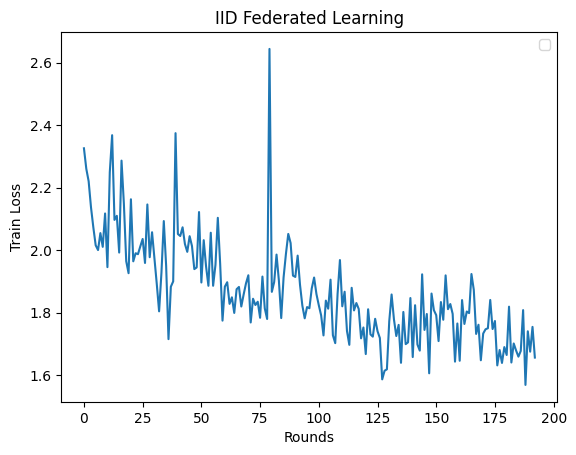

In [5]:
plt.plot(device['train_loss_tracker'])

plt.xlabel('Rounds')
plt.ylabel('Train Loss')
plt.title('IID Federated Learning')

plt.legend()

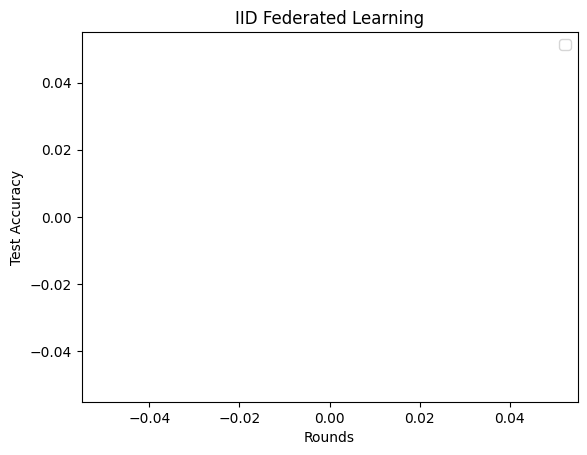

In [6]:
plt.plot(device['test_acc_tracker'])

plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.title('IID Federated Learning')

plt.legend()

**Implementing Components for Federated Learning**

In **PART 1.1**, you implemented `iid_sampler`, created a 10% subset of the CIFAR-10 training set, and used it to train a single client device model. Since the client only had a 10% subset of the full CIFAR-10 training set, it performed significantly worse than the same model trained on the entire training set.

Federated Learning aims to improve the performance of these client devices by averaging the updates from multiple clients over the course of training. This way, a centralized server is able to be updated using the training data stored on local devices without having access to the training data.
By using more client devices, you will be able to leverage the entire dataset.
In a way, this simulates traditional gradient descent, but with additional epochs performed on each client before averaging, where each epoch uses mini-batches of size 128.
An additional benefit of federated learning is that the centralized server does not require large compute resources, as most of the training computation is performed on local devices.
This makes the training computation "free" for the centralized server, as the clients pay the compute cost on their local devices.

---
<font color='red'>**PART 1.2:**</font> [10 points]

Before implementing Federated Learning, you must implement two functions which will be used during the training process.

The `average_weights` function takes in multiple device models, and computes the average for each model parameter across all models. This function will be called by the centralized server to aggregate the training performed by the end user devices. This averaging is done in 32-bit floating point (`float32`).

The `get_devices_for_round` function will be used to simulate the device rejection phase shown earlier in the figure in the **Federated Learning Overview** section. This function will select a percentage of devices to participate in each training round.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.5*, implement `average_weights`. We have provided test code you can use to validate your implementation. This test code will also be useful for the full implementation of Federated Learning in **PART 1.3**.
2. In *Code Cell 1.5*, implement the `get_devices_for_round` function. Try multiple `device_pct` settings to ensure that it is working properly.
---

In [5]:
## Code Cell 1.5
import copy


def average_weights(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    # Part 1.2: Implement!
    # Hint: device['net'].state_dict() will return an OrderedDict of all
    #       tensors in the model. Return the average of each tensor using
    #       and OrderedDict so that you can update the global model using
    #       device['net'].load_state_dict(w_avg), where w_avg is the
    #       averaged OrderedDict over all devices
    num_devices = len(devices)
    state_dict = copy.deepcopy(devices[0]['net'].state_dict())
    layers_list = list(state_dict.keys())
    for i, device in enumerate(devices):
      if i != 0:
        for layer in layers_list[:4]:  # debugged -- only first 4 items are layers
          state_dict[layer] += copy.deepcopy(device['net'].state_dict())[layer]
          if i == num_devices - 1:
            # print(layer)
            # print(state_dict[layer])
            state_dict[layer] /= num_devices  # debugged: need to divide by number of devices to average
    return state_dict


def get_devices_for_round(devices, device_pct):
    '''
    '''
    # Part 1.2: Implement!
    num_devices = len(devices)
    device_idxs = random.sample(range(num_devices), int(num_devices * device_pct))
    return [devices[i] for i in device_idxs]  # debugged -- need to return devices not just indices like above


# Test code for average_weights
# Hint: This test may be useful for Part 1.3!
class TestNetwork(nn.Module):
    '''
    A simple 2 layer MLP used for testing your average_weights implementation.
    '''
    def __init__(self):
        super(TestNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 2)
        self.layer2 = nn.Linear(2, 4)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        return self.layer2(h)

data_pct = 0.05
num_devices = 2
net = TestNetwork()
data_idxs = iid_sampler(trainset, num_devices, data_pct)
devices = [create_device(net, i, trainset, data_idxs[i])
           for i in range(num_devices)]

# Fixed seeding to compare against precomputed correct_weight_averages below
torch.manual_seed(0)
devices[0]['net'].layer1.weight.data.normal_()
devices[0]['net'].layer1.bias.data.normal_()
devices[0]['net'].layer2.weight.data.normal_()
devices[0]['net'].layer2.bias.data.normal_()
devices[1]['net'].layer1.weight.data.normal_()
devices[1]['net'].layer1.bias.data.normal_()
devices[1]['net'].layer2.weight.data.normal_()
devices[1]['net'].layer2.bias.data.normal_()

# Precomputed correct averages
correct_weight_averages = OrderedDict(
    [('layer1.weight', torch.tensor([[ 0.3245, -0.9013], [-0.9042,  1.0125]])),
     ('layer1.bias', torch.tensor([-0.0724, -0.3119])),
     ('layer2.weight', torch.tensor([[0.2976,  1.0509], [-1.0048, -0.5972],
                                     [-0.3088, -0.2682], [-0.1690, -0.1060]])),
     ('layer2.bias', torch.tensor([-0.4396,  0.3327, -1.3925,  0.3160]))
    ])

# Computed weight averages
computed_weight_averages = average_weights(devices)
# print(computed_weight_averages)

mismatch_found = False
for correct, computed in zip(correct_weight_averages.items(),
                             computed_weight_averages.items()):
    if not torch.allclose(correct[1], computed[1], atol=1e-2):
        mismatch_found = True
        print('Mismatch in tensor:', correct[0])

if not mismatch_found:
    print('Implementation output matches!')

Implementation output matches!


**Federated Learning Training**

---
<font color='red'>**PART 1.3:**</font> [10 points]

We will now run the federated learning in the IID setting using the functions you previously wrote in this section.
The parameters are given to you in the code.
You will use 100 rounds of federated learning updates.
For each round, each device that participates in a given round will complete 4 epochs of local training.
10% of devices should participate in each round, selected by the `get_devices_for_round` function you wrote previously.
Note that we use static initialization for the models between all parts of the assignment.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.6*, train a global model via federated learning.
Much of the code has been given to you, but you will need to fill in the parts using calls to the functions you wrote above.

2. Graph the accuracy of the global model over 100 rounds.
Discuss the accuracy difference between the global model trained here and the individual local model you trained in **PART 1.1**. (50 words maximum)

In [6]:
## Code Cell 1.6

# use these parameters
rounds = 100 # Part 1.3: Change to 100 epochs
local_epochs = 4
num_devices = 50
device_pct = 0.1
data_pct = 0.1
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()

data_idxs = iid_sampler(trainset, num_devices, data_pct)

# Part 1.3: Implement device creation here
devices = [create_device(net, 'cuda' + str(i), trainset, data_idxs[i]) for i in range(num_devices)]
# print(len(devices))
# print(devices[0]['net'])
# round_devices = get_devices_for_round(devices, data_pct)

## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    # Part 1.3: Implement getting devices for each round here

    round_devices = get_devices_for_round(devices, data_pct)
    # print('Round: ', round_num)
    # print(len(round_devices))
    # print(round_devices)
    for device in round_devices:
        # print(device)
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # test accuracy after aggregation
    test(round_num, devices[0])


total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

(Device cuda27/Epoch 1) Train Loss: 1.969 | Train Acc: 26.146

KeyboardInterrupt: ignored

In [ ]:
test_acc_tracker32 = [31.060, 35.520, 42.460, 49.350, 52.590, 56.380, 59.080, 62.320, 65.430, 65.590,
                      69.190, 69.650, 68.200, 69.640, 72.460, 74.890, 73.190, 73.780, 73.510, 74.210,
                      77.310, 76.640, 77.610, 77.260, 79.080, 79.860, 80.390, 80.530, 80.570, 80.900,
                      80.990, 80.800, 80.760, 80.930, 81.000, 80.750, 80.780, 80.920, 81.390, 81.130,
                      81.800, 81.390, 80.590, 80.990, 81.150, 81.170, 80.680, 81.160, 81.460, 81.450,
                      81.630, 81.790, 81.720, 81.720, 81.780, 81.850, 82.030, 81.830, 81.690, 81.710,
                      81.770, 81.680, 81.740, 81.830, 81.780, 81.800, 81.850, 81.940, 82.020, 82.020,
                      81.970, 82.060, 82.110, 82.160, 82.100, 82.120, 82.140, 82.070, 82.130, 82.060,
                      82.060, 82.080, 82.060, 82.110, 82.160, 82.160, 82.090, 82.110, 82.110, 82.150,
                      82.120, 82.110, 82.110, 82.020, 82.050, 82.040, 82.040, 82.070, 82.080, 82.070]

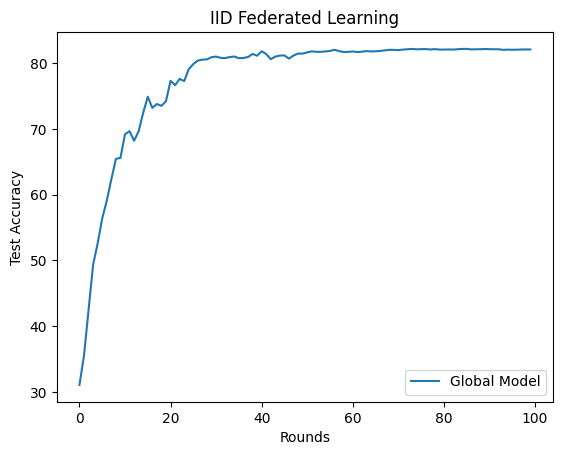

In [ ]:
plt.plot(test_acc_tracker32, label='Global Model')

plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.title('IID Federated Learning')

plt.legend()

---

### **2. Non-IID Federated Learning and Fairness**

---
**Overview**

In **PART 1**, you implemented a Federated Learning pipeline that operated on IID data.
While this IID assumption may hold in some applications, it does not hold in many other settings.
For example, a group of similar users may have data that is fundamentally different from that of another group of users.
As a result, the aggregate data that federated learning operates on will be non-IID in nature.

In **PART 2** of the assignment, you will explore using Federated Learning in a non-IID setting.
In this part of the assignment, you will create groups of devices such that the inter-group data is non-IID and the intra-group data is IID.
To do this, you will reimplement many of the functions you implemented in **PART 1** for this non-IID setting.

For all experiments in this section, we assume there are three groups.
Each group is assigned a different subset of classes in the dataset (Group 0 is assigned data from classes 0-3, Group 1 from classes 4-6, and Group 2 from classes 7-9).
We also fix each group to contain 20 devices, although you will vary per-group participation rates in each round in **PART 2.4**.

---
**Non-IID Sampling**

<font color='red'>**PART 2.1:**</font> [10 points]

We will first start by implementing `noniid_group_sampler`, a new, non-IID group version of the `iid_sampler` you implemented in PART 1.  We will use this function to generate training subsets for multiple devices in PART 2.4.  

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.1*, implement the `noniid_group_sampler` function to generate **non-IID** samples from the CIFAR-10 training set.
As input, the function should take the dataset and number of training samples each device should be assigned.
As in `iid_sampler` you implemented previously, the function should return a `dict` where each key is a device ID number and each value is a `set` of the indices of training samples in the dataset assigned to that device.
You may want to have the function return other data as well, depending on how you implement functions in later parts of the assignment.
We have provided the mapping that indicates which classes are mapped to each group.
Within a given group, you should sample the data in an IID fashion.
---

In [7]:
## Code Cell 2.1

# creates noniid TRAINING datasets for each group
def noniid_group_sampler(dataset, num_items_per_device):
  '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    num_items_per_device: how many samples to assign to each device

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

  '''

  # how many devices per non-iid group
  devices_per_group = [20, 20, 20]

  # label assignment per group
  dict_group_classes = {}
  dict_group_classes[0] = [0,1,2,3]
  dict_group_classes[1] = [4,5,6]
  dict_group_classes[2] = [7,8,9]

  sampled_tmp = {0: [], 1: [], 2: []}
  # Part 2.1: Implement!
  for i, example in enumerate(dataset):
    if example[1] in dict_group_classes[0]:
      sampled_tmp[0].append(i)
    elif example[1] in dict_group_classes[1]:
      sampled_tmp[1].append(i)
    elif example[1] in dict_group_classes[2]:
      sampled_tmp[2].append(i)

  idx = 0
  sampled = {}
  for i in range(60):
    sampled[i] = random.sample(sampled_tmp[idx], num_items_per_device)
    if i % 20 == -1 % 20:  # debugged -- issue with dataset indices not working properly, cannot use -1, must use 19 or (-1 mod 20)
      idx += 1
  return sampled


---
**Group-based Device Rejection**

<font color='red'>**PART 2.2:**</font> [5 points]

We will now implement `get_devices_for_round_GROUP`, a new group-based version of the `get_devices_for_round` you implemented in **PART 1**.
We will use this function in **PART 2.4** to simulate the device rejection phase shown earlier on a per-group basis.  

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.2*, implement the `get_devices_for_round_GROUP` function to generate a list of devices that will participate in each round of federated learning.
The function should, at minimum, take as input 1) the list of all devices, and 2) how many devices from each group should participate in a given round.
It should return a list of devices that will participate in a given round.
You may want to add additional input parameters depending on your implementation strategy.

In [8]:
## Code Cell 2.2

# get which devices in each group should participate in a current round
# by explicitly saying number of each devices desired for each group
def get_devices_for_round_GROUP(devices, device_nums, user_group_idxs):
  # PART 2.2: Implement!
  # Assume first 20 are group 0, second 20 are group 1, third 20 are group 2

  device_idxs = sum([random.sample(range(i*20, i*20+20), device_nums[i]) for i in range(3)], [])
  return [devices[i] for i in device_idxs]

---
**Group-based Testing**

<font color='red'>**PART 2.3:**</font> [5 points]

We will now implement the testing functions needed to evaluate the global model learned via Federated Learning on a per-group basis.  This will require two functions:



* `cifar_noniid_group_test` divides the test dataset into three subsets, one subset for each group.
* `test_group` gets per-group classification accuracy for the global model.
You will likely want to start with the `test` function from **Code Cell 1.2** and modify it to work on a per-group basis.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.3*, implement the `cifar_noniid_group_test` function to create a test dataset for each group.
It should take the full CIFAR-10 test dataset as input, and return a `dict` where each key is a group ID, and each value is a `set` of the indices for all test samples for that group.

2.  In *Code Cell 2.3*, implement the `test_group` function to output the per-group classification accuracy of the global model.



In [9]:
## Code Cell 2.3

# creates noniid TEST datasets for each group
def cifar_noniid_group_test(dataset):
  dict_group_classes = {}
  dict_group_classes[0] = [0,1,2,3]
  dict_group_classes[1] = [4,5,6]
  dict_group_classes[2] = [7,8,9]

  # Part 2.3: Implement!
  tests_by_group = {0: [], 1: [], 2: []}
  # same as part 2.1, except just the first part
  for i, example in enumerate(dataset):
    if example[1] in dict_group_classes[0]:
      tests_by_group[0].append(i)
    elif example[1] in dict_group_classes[1]:
      tests_by_group[1].append(i)
    elif example[1] in dict_group_classes[2]:
      tests_by_group[2].append(i)

  return tests_by_group

# gets per-group accuracy of global model
def test_group(epoch, device, group_idxs_dict):

    # Part 2.3: Implement!
    # Hint: refer to test function in PART 1
    # Hint: check https://pytorch.org/docs/stable/data.html?highlight=subset#torch.utils.data.Subset
    net.eval()
    test_loss, correct, total = 0, 0, 0
    acc = {}
    # loop through all 3 groups
    for i in range(3):
      # get associated indices
      idxs = group_idxs_dict[i]
      # create dataset subset based on indices
      group_dataset = torch.utils.data.Subset(testset, idxs)
      # recreate testloader to include only the dataset from group indices
      testloader = torch.utils.data.DataLoader(group_dataset, batch_size=128, shuffle=False) # debugged -- need to use subset to recreate dataloader
      # same test iteration as usual, except track all three accuracies by using accuracy dictionary
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(testloader):
            if batch_idx in idxs:
              inputs, targets = inputs.cuda(), targets.cuda()
              outputs = device['net'](inputs)
              loss = criterion(outputs, targets)
              test_loss += loss.item()
              device['test_loss_tracker'].append(loss.item())
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
              loss = test_loss / (batch_idx + 1)
              acc[i] = 100.* correct / total

    sys.stdout.write(f'\nGroup 1 Test Acc: {acc[0]:.3f} | Group 2 Test Acc: {acc[1]:.3f} | Group 3 Test Acc: {acc[2]:.3f} \n')
    sys.stdout.flush()
    device['test_acc_tracker'].append(acc)


---
**Federated Learning Results in Non-IID Setting**

<font color='red'>**PART 2.4:**</font> [10 points]

We will now run federated learning in the non-IID setting using the functions you previously wrote.
We will examine two different scenarios.

**Fair Device Participation:** run federated learning on the CIFAR-10 dataset with three groups.
Each group should have exactly one device participate in each round.

**Unfair Device Participation:** run federated learning on the CIFAR-10 dataset with three groups.
Group 0 should have five devices participate in each round, and Groups 1 and 2 should each only have one device participate in each round.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.4*, train a global model via federated learning for the group-based non-IID setting.  Much of the code has been given to you, but you will need to fill in the parts using calls to the group-based, non-iid functions you wrote above.
(Hint: you will likely be able to re-use parts of the code you wrote in **Part 1.3**.)

2. Graph the per-group test accuracy over 100 rounds for the **Fair Device Participation** scenario. Each group should have its own line in the graph.

3.  Graph the per-group test accuracy over 100 rounds in the **Unfair Device Participation** scenario. Each group should have its own line in the graph.

4.  Describe the differences you see between the two scenarios. How can you explain what you are seeing?  (100 words maximum)

In [25]:
## Code Cell 2.4
## FAIR VERSION
## Using A100/V100 GPUs (speeds may be significantly faster)

rounds = 100
local_epochs = 1
num_items_per_device = 5000
device_nums = [1, 1, 1]
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones=[250, 500, 750]

# Part 2.4: Implement non-iid sampling
data_idxs = noniid_group_sampler(trainset, num_items_per_device)

# create devices
devices = [create_device(net, 'cuda' + str(i), trainset, data_idxs[i]) for i in range(60)] # Implement this!

test_idxs = cifar_noniid_group_test(testset)
## Non-IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    print(f"Round: {round_num}\n")
    # Get devices for each round
    round_devices = get_devices_for_round_GROUP(devices, device_nums, None)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # Test accuracy
    test_group(round_num, device, test_idxs)

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Round: 0

(Device cuda43/Epoch 0) Train Loss: 0.867 | Train Acc: 62.240
Group 1 Test Acc: 0.000 | Group 2 Test Acc: 0.000 | Group 3 Test Acc: 21.714 
Round: 1

(Device cuda52/Epoch 0) Train Loss: 0.653 | Train Acc: 73.000
Group 1 Test Acc: 0.000 | Group 2 Test Acc: 0.000 | Group 3 Test Acc: 26.966 
Round: 2

(Device cuda56/Epoch 0) Train Loss: 0.539 | Train Acc: 78.180
Group 1 Test Acc: 0.000 | Group 2 Test Acc: 0.000 | Group 3 Test Acc: 26.382 
Round: 3

(Device cuda50/Epoch 0) Train Loss: 0.552 | Train Acc: 77.360
Group 1 Test Acc: 0.000 | Group 2 Test Acc: 0.000 | Group 3 Test Acc: 29.699 
Round: 4

(Device cuda53/Epoch 0) Train Loss: 0.518 | Train Acc: 80.300
Group 1 Test Acc: 0.000 | Group 2 Test Acc: 0.000 | Group 3 Test Acc: 30.713 
Round: 5

(Device cuda42/Epoch 0) Train Loss: 0.417 | Train Acc: 83.758

KeyboardInterrupt: ignored

[[48.775, 0.0, 0.0], [44.15, 0.0, 0.0], [56.15, 0.0, 0.0], [60.5, 0.0, 0.0], [62.95, 0.0, 0.0], [60.475, 0.0, 0.0], [63.375, 0.0, 0.0], [64.475, 0.0, 0.0], [65.0, 0.0, 0.0], [65.375, 0.0, 0.0], [68.475, 0.0, 0.0], [69.625, 0.0, 0.0], [58.6, 0.0, 0.0], [67.1, 0.0, 0.0], [64.35, 0.0, 0.0], [70.175, 0.0, 0.0], [66.95, 0.0, 0.0], [70.975, 0.0, 0.0], [70.025, 0.0, 0.0], [70.0, 0.0, 0.0], [71.5, 0.0, 0.0], [55.95, 0.0, 0.0], [67.525, 0.0, 0.0], [67.85, 0.0, 0.0], [70.55, 0.0, 0.0], [71.125, 0.0, 0.0], [72.45, 0.0, 0.0], [72.4, 0.0, 0.0], [71.25, 0.0, 0.0], [71.45, 0.0, 0.0], [60.1, 0.0, 0.0], [65.775, 0.0, 0.0], [65.375, 0.0, 0.0], [66.0, 0.0, 0.0], [59.3, 0.0, 0.0], [46.975, 0.0, 0.0], [52.625, 0.0, 0.0], [45.925, 0.0, 0.0], [37.575, 0.0, 0.0], [57.775, 0.0, 0.0], [37.8, 0.0, 0.0], [52.825, 0.0, 0.0], [40.425, 0.0, 0.0], [66.3, 0.0, 0.0], [69.2, 0.0, 0.0], [69.075, 0.0, 0.0], [68.775, 0.0, 0.0], [68.55, 0.0, 0.0], [70.7, 0.0, 0.0], [71.575, 0.0, 0.0], [71.4, 0.0, 0.0], [71.825, 0.0, 0.0], [

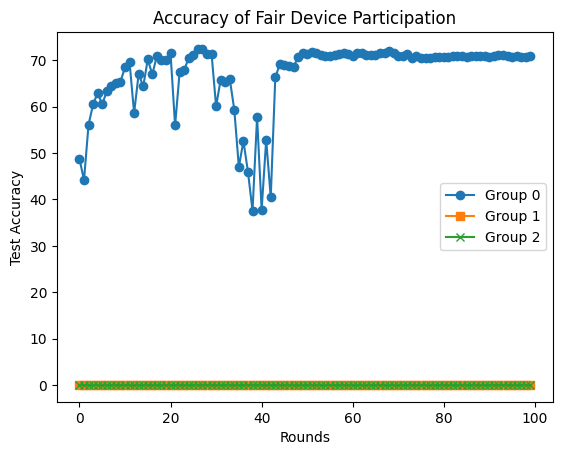

In [ ]:
plt.plot([elt[0] for elt in device['test_acc_tracker']], label='Group 0', marker='o')
plt.plot([elt[1] for elt in device['test_acc_tracker']], label='Group 1', marker='s')
plt.plot([elt[2] for elt in device['test_acc_tracker']], label='Group 2', marker='x')

plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.title('Accuracy of Fair Device Participation')

plt.legend()

print(device['test_acc_tracker'])

Text(0.5, 1.0, 'Accuracy of Fair Device Participation')

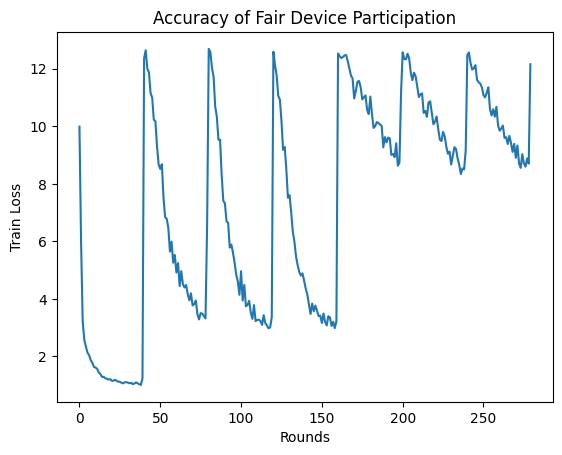

In [ ]:
plt.plot(device['train_loss_tracker'])
plt.xlabel('Rounds')
plt.ylabel('Train Loss')
plt.title('Accuracy of Fair Device Participation')

In [10]:
## UNFAIR VERSION

rounds = 100
local_epochs = 1
num_items_per_device = 5000
device_nums = [5, 1, 1]
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones=[250, 500, 750]

# Part 2.4: Implement non-iid sampling
data_idxs = noniid_group_sampler(trainset, num_items_per_device)

# Part 2.4: Implement device creation here
devices = [create_device(net, 'cuda' + str(i), trainset, data_idxs[i]) for i in range(60)] # Implement this!

test_idxs = cifar_noniid_group_test(testset)
## Non-IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    print(f"Round: {round_num}\n")
    # Get devices for each round
    round_devices = get_devices_for_round_GROUP(devices, device_nums, None)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # Test accuracy
    test_group(round_num, device, test_idxs)

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Round: 0

(Device cuda53/Epoch 0) Train Loss: 0.873 | Train Acc: 62.540
Group 1 Test Acc: 51.302 | Group 2 Test Acc: 28.857 | Group 3 Test Acc: 18.151 
Round: 1

(Device cuda43/Epoch 0) Train Loss: 1.899 | Train Acc: 50.340
Group 1 Test Acc: 52.778 | Group 2 Test Acc: 29.688 | Group 3 Test Acc: 18.673 
Round: 2

(Device cuda54/Epoch 0) Train Loss: 2.124 | Train Acc: 34.340
Group 1 Test Acc: 53.819 | Group 2 Test Acc: 30.273 | Group 3 Test Acc: 19.042 
Round: 3

(Device cuda48/Epoch 0) Train Loss: 1.766 | Train Acc: 41.360
Group 1 Test Acc: 61.372 | Group 2 Test Acc: 34.521 | Group 3 Test Acc: 21.714 
Round: 4

(Device cuda56/Epoch 0) Train Loss: 1.788 | Train Acc: 33.580
Group 1 Test Acc: 65.104 | Group 2 Test Acc: 36.621 | Group 3 Test Acc: 23.034 
Round: 5

(Device cuda40/Epoch 0) Train Loss: 1.821 | Train Acc: 32.220
Group 1 Test Acc: 60.417 | Group 2 Test Acc: 33.984 | Group 3 Test Acc: 21.376 
Round: 6

(Device cuda47/Epoch 0) Train Loss: 1.785 | Train Acc: 32.020
Group 1 Test Acc

[{0: 51.302083333333336, 1: 28.857421875, 2: 18.151105651105652}, {0: 52.77777777777778, 1: 29.6875, 2: 18.673218673218674}, {0: 53.81944444444444, 1: 30.2734375, 2: 19.04176904176904}, {0: 61.37152777777778, 1: 34.521484375, 2: 21.713759213759214}, {0: 65.10416666666667, 1: 36.62109375, 2: 23.034398034398034}, {0: 60.416666666666664, 1: 33.984375, 2: 21.375921375921376}, {0: 59.72222222222222, 1: 33.59375, 2: 21.13022113022113}, {0: 68.57638888888889, 1: 38.57421875, 2: 24.262899262899264}, {0: 69.79166666666667, 1: 39.2578125, 2: 24.692874692874692}, {0: 64.23611111111111, 1: 36.1328125, 2: 22.727272727272727}, {0: 65.97222222222223, 1: 37.109375, 2: 23.34152334152334}, {0: 71.875, 1: 40.4296875, 2: 25.42997542997543}, {0: 66.23263888888889, 1: 37.255859375, 2: 23.433660933660935}, {0: 72.65625, 1: 40.869140625, 2: 25.706388206388205}, {0: 55.46875, 1: 31.201171875, 2: 19.625307125307124}, {0: 70.83333333333333, 1: 39.84375, 2: 25.061425061425062}, {0: 73.52430555555556, 1: 41.357421

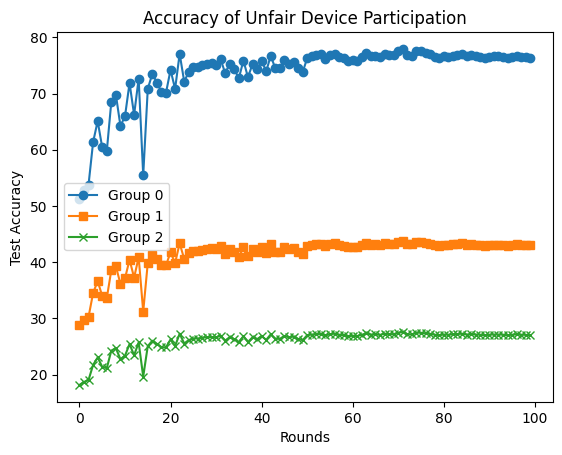

In [11]:
# plot unfair device participation test accuracy

plt.plot([elt[0] for elt in device['test_acc_tracker']], label='Group 0', marker='o')
plt.plot([elt[1] for elt in device['test_acc_tracker']], label='Group 1', marker='s')
plt.plot([elt[2] for elt in device['test_acc_tracker']], label='Group 2', marker='x')

plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.title('Accuracy of Unfair Device Participation')

plt.legend()

print(device['test_acc_tracker'])

Text(0.5, 1.0, 'Loss of Unfair Device Participation')

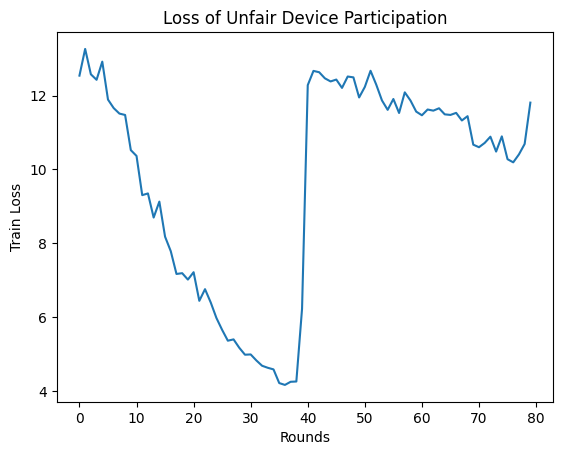

In [13]:
# plot unfair device participation loss
plt.plot(device['train_loss_tracker'])
plt.xlabel('Rounds')
plt.ylabel('Train Loss')
plt.title('Loss of Unfair Device Participation')

----
### **3. Quantization of Local Models for Reduced Communication Cost**
-----
Quantization refers to the process of reducing the number of bits used to represent a number. In the context of deep learning, the predominant numerical format used in research and deployment has been 32-bit floating-point ([IEEE 754 Format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format)).
However, the desire for reduced model size and computation has led to research on using fewer bits to represent numbers in deep learning models.
This can impact several aspects of the pipeline, including computation, communication, and storage requirements.
For example, in the context of federated learning, quantizing a client model from full (32-bit) precision to 8-bit precision will reduce the model size by ~4×.
Furthermore, because the model size is reduced, the communication required for uploading a client model is also reduced by ~4× as well.

However, this quantization comes with trade-offs.
To see this, consider a full precision representation (32-bit floating point). This representation has a large dynamic range (from $-3.4\times 10^{38}$ to $+3.4\times10^{38}$) and high precision (about $7$ decimal digits).
As a result, a full precision number can be seen as continuous data.
In contrast, $n$-bit fixed-point representations are limited to $2^n$ discrete values.
$n$-bit quantization generally refers to projecting a full precision weight to one of these $2^n$ discrete values by finding its nearest neighbor.  

--------
<font color='red'>**PART 3.1:**</font> [5 points]

In this part, we will write a function to project full-precision numbers into $n$-bit fixed-point numbers.
For example, suppose we want to project full-precision numbers in the range of $[0, 1]$ into an 8-bit fixed point representation, $\frac{1}{2^8-1}\times(0, 1, 2, 3, \dots, 253, 254,255)$, where $\frac{1}{2^8-1}$ is the **scale factor** of the 8-bit fixed-point representation.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.1*, implement a function that converts full-precision numbers in the range $[0, 1]$ into $n$-bit fixed-point numbers.
If your implementation is correct, it should return *'Output of Quantization Matches!'*.

In [ ]:
## Code Cell 3.1

def quantizer(input, nbit):
    '''
    input: full precision tensor in the range [0, 1]
    return: quantized tensor
    '''
    # Part 3.1: Implement!
    # Hint: torch.round

    # For nbit bits, this is the possible range of values for the input
    range = 2 ** nbit - 1

    #
    output = torch.round(input * range) / range

    return output


# Test Code
test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([0.0000, 0.0667, 0.2000, 0.2667, 0.3333, 0.4667,
                             0.5333, 0.6667, 0.7333, 0.8000, 0.9333])

# output of your quantization function
quantizer_output = quantizer(test_data, 4)

if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

Output of Quantization Matches!


**Quantize Weights of Neural Networks**

The quantizer in **PART 3.1** will quantize any full-precision number in the range of $[0, 1]$ into an $n$-bit fixed-point number.
However, a weight $w$ in a neural network is not necessarily in the range $[0, 1]$.

To use the quantizer in **PART 3.1**, we will first use a scaling function to transform weights into the range of $[0 ,1]$:
$$\tilde{w} = \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2}$$
where $2 \cdot \max(|w|)$ is the **adaptive scale**.

Then, we quantize the transformed weights:
$$\hat{w} = \text{quantizer}_{\text{n-bit}}(\tilde{w})$$
After quantization, a reverse scaling function can be applied on $\hat{w}$ to recover the original scale:

$$w_q = 2 \cdot \max(|w|) \cdot \left( \hat{w}-\frac{1}{2} \right)$$

Combining these three equations, the expression we will use to get the quantized weights $w_q$ is as follows:
$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2\max(|w|)} + \frac{1}{2} \right) - \frac{1}{2} \right]$$

This equation is the **deterministic quantization function**.

Following the method proposed by [DoReFa-Net](https://arxiv.org/abs/1606.06160), we enable *stochastic quantization* by adding extra noise $N(n) = \frac{\sigma}{2^n-1}$ to the transformed weights $\tilde{w}$, where $\sigma \sim \text{Uniform}(-0.5, 0.5)$ and $n$ is the number of bits.
Generally, including such extra noise will coax the model into exploring more of the loss surface, helping the model escape local minima and improve model generalizability.  

The final **stochastic quantization function** we will use to quantize layers of local models is:

$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2} + N(n) \right) - \frac{1}{2} \right]$$


<font color='red'>**PART 3.2:**</font> [10 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.2*, implement `dorefa_g(w, nbit, adaptive_scale=None)` using the **stochastic quantization function** shown above. Again, if your implementation is correct, it should return *'Output of Quantization Matches!'*.


In [ ]:
## Code Cell 3.2

def quantize_model(model, nbit):
    '''
    Used in Code Cell 3.3 to quantize the ConvNet model
    '''
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.weight.data, m.adaptive_scale = dorefa_g(m.weight, nbit)
            if m.bias is not None:
                m.bias.data,_ = dorefa_g(m.bias, nbit, m.adaptive_scale)

def dorefa_g(w, nbit, adaptive_scale=None):
    '''
    w: a floating-point weight tensor to quantize
    nbit: the number of bits in the quantized representation
    adaptive_scale: the maximum scale value. if None, it is set to be the
                    absolute maximum value in w.
    '''
    if adaptive_scale is None:
        adaptive_scale = 2 * torch.max(torch.abs(w))

    # Part 3.2: Implement based on stochastic quantization function above

    # Function that adds uniform noise to the values to be quantized, scaled over range of bits
    def N(n):
        sigma = np.random.uniform(-.5, .5)
        return sigma / (2**n - 1)

    # Scale the weights
    w_tilde = w / adaptive_scale + 1/2

    # Quantize the weights
    w_q = adaptive_scale * (quantizer(w_tilde + N(nbit), nbit) - 1/2)

    return w_q, adaptive_scale


# Test Code
test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([-0.0606, 0.0606, 0.1818, 0.3030, 0.3030, 0.4242,
                             0.5455, 0.5455, 0.7879, 0.7879, 0.9091])

# output of your quantization function
torch.manual_seed(43)
quantizer_output, adaptive_scale = dorefa_g(test_data, 4)

print(ground_truth)
print(quantizer_output)
if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

**Reduce the Communication Overhead with Quantization**

We will now explore the performance impact of quantization on federated learning. We will use the IID setting from **PART 1**. You will use the same federated learning code, but will first quantize each local model with the `quantize_model` function you wrote above before uploading to the central server (*Line 27, Code Cell 3.3*).

<font color='red'>**PART 3.3:**</font> [10 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.3*, run federated learning with the following two quantization settings (bit widths): `nbit=16` and `nbit=4`. Plot the accuracy of the global models over 100 rounds for the different bit widths: 32-bit (the full-precision baseline you ran previously), 16-bit, and 4-bit.  
2. Discuss the accuracy difference between the global models across the three different bit width settings: 32-bit, 16-bit, and 4-bit. (100 words maximum)

In [ ]:
## Code Cell 3.3

# Part 3.2: Train two settings with nbit=16 and nbit=4.
#           Compare against the floating-point performance
#           of the final FL model trained in Part 1.3.

# Function for federated learning with quantization
def federated_learning_quantization(nbit):
    rounds = 100
    local_epochs = 4
    num_devices = 50
    data_pct = 0.1
    device_pct = 0.1
    net = ConvNet().cuda()
    quantize_model(net, nbit) # Model is quantized
    criterion = nn.CrossEntropyLoss()
    milestones = [250, 500, 750]

    # Model weights are copied to new model in order to be compatible with copy.deepcopy(net)
    def copy_model(model):
      new_model = ConvNet().cuda()
      new_model.load_state_dict(model.state_dict())
      return new_model

    net = copy_model(net)

    data_idxs = iid_sampler(trainset, num_devices, data_pct)

    devices = [create_device(net, 'cuda' + str(i), trainset, data_idxs[i]) for i in range(num_devices)]

    ## IID Federated Learning
    start_time = time.time()
    for round_num in range(rounds):
        round_devices = get_devices_for_round(devices, data_pct)
        # print('Round: ', round_num)
        # print(len(round_devices))
        # print(round_devices)
        for device in round_devices:
            # print(device)
            for local_epoch in range(local_epochs):
                train(local_epoch, device)

        # Weight averaging
        w_avg = average_weights(round_devices)

        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # test accuracy after aggregation
        test(round_num, devices[0])

    total_time = time.time() - start_time
    print('Total training time: {} seconds'.format(total_time))

    return devices[0]['test_acc_tracker']

nbit=16
print('Quantized Federated Learning: {} bits'.format(nbit))
test_acc_tracker16 = federated_learning_quantization(nbit)

Quantized Federated Learning: 16 bits
(Device cuda26/Epoch 3) Train Loss: 1.768 | Train Acc: 33.380 | Test Loss: 1.730 | Test Acc: 36.320
(Device cuda24/Epoch 3) Train Loss: 1.474 | Train Acc: 45.680 | Test Loss: 1.520 | Test Acc: 43.280
(Device cuda20/Epoch 3) Train Loss: 1.451 | Train Acc: 45.820 | Test Loss: 1.339 | Test Acc: 50.510
(Device cuda34/Epoch 3) Train Loss: 1.215 | Train Acc: 55.260 | Test Loss: 1.205 | Test Acc: 56.620
(Device cuda10/Epoch 3) Train Loss: 1.049 | Train Acc: 61.760 | Test Loss: 1.108 | Test Acc: 60.390
(Device cuda13/Epoch 3) Train Loss: 0.943 | Train Acc: 66.480 | Test Loss: 1.023 | Test Acc: 63.110
(Device cuda20/Epoch 3) Train Loss: 0.827 | Train Acc: 70.100 | Test Loss: 1.027 | Test Acc: 63.370
(Device cuda15/Epoch 3) Train Loss: 0.852 | Train Acc: 68.760 | Test Loss: 0.940 | Test Acc: 67.270
(Device cuda35/Epoch 3) Train Loss: 0.780 | Train Acc: 72.360 | Test Loss: 0.894 | Test Acc: 69.560
(Device cuda9/Epoch 3) Train Loss: 0.739 | Train Acc: 74.280 |

In [ ]:
nbit=4
print('Quantized Federated Learning: {} bits'.format(nbit))
test_acc_tracker4 = federated_learning_quantization(nbit)

Quantized Federated Learning: 4 bits
(Device cuda27/Epoch 3) Train Loss: 1.780 | Train Acc: 32.240 | Test Loss: 1.790 | Test Acc: 36.020
(Device cuda48/Epoch 3) Train Loss: 1.520 | Train Acc: 43.820 | Test Loss: 1.503 | Test Acc: 44.840
(Device cuda34/Epoch 3) Train Loss: 1.376 | Train Acc: 49.680 | Test Loss: 1.403 | Test Acc: 49.160
(Device cuda49/Epoch 3) Train Loss: 1.200 | Train Acc: 56.560 | Test Loss: 1.226 | Test Acc: 56.070
(Device cuda13/Epoch 3) Train Loss: 1.125 | Train Acc: 58.000 | Test Loss: 1.135 | Test Acc: 59.730
(Device cuda34/Epoch 3) Train Loss: 0.988 | Train Acc: 64.840 | Test Loss: 1.043 | Test Acc: 62.740
(Device cuda37/Epoch 3) Train Loss: 0.973 | Train Acc: 66.160 | Test Loss: 1.018 | Test Acc: 63.780
(Device cuda6/Epoch 3) Train Loss: 0.897 | Train Acc: 68.540 | Test Loss: 0.948 | Test Acc: 67.360
(Device cuda3/Epoch 3) Train Loss: 0.741 | Train Acc: 72.540 | Test Loss: 0.894 | Test Acc: 69.030
(Device cuda5/Epoch 3) Train Loss: 0.726 | Train Acc: 74.240 | Te

KeyboardInterrupt: ignored

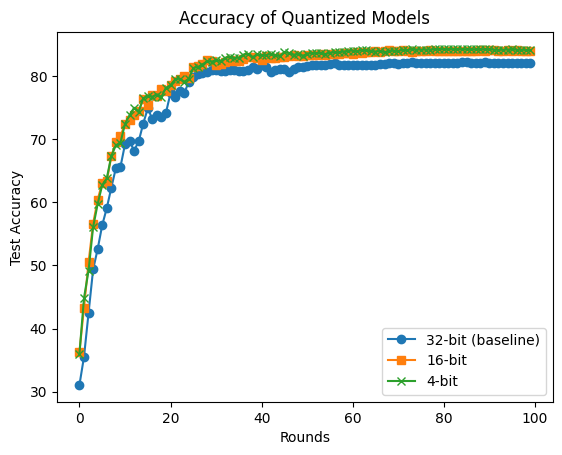

In [ ]:
# Plot accuracies from quantized models

test_acc_tracker16 = [36.320, 43.280, 50.510, 56.620, 60.390, 63.110, 63.370, 67.270, 69.560, 70.510,
                      72.370, 73.040, 73.820, 74.410, 76.370, 75.380, 76.930, 76.850, 77.920, 77.570,
                      78.550, 79.230, 79.530, 80.000, 79.750, 81.460, 81.670, 81.850, 82.500, 82.400,
                      81.740, 81.980, 82.300, 82.550, 82.380, 82.350, 82.690, 83.050, 82.950, 82.820,
                      82.600, 83.100, 82.860, 82.900, 83.060, 83.050, 83.220, 83.290, 83.160, 83.170,
                      83.340, 83.320, 83.400, 83.440, 83.370, 83.430, 83.490, 83.550, 83.670, 83.660,
                      83.550, 83.800, 83.710, 83.820, 83.770, 83.960, 83.760, 83.940, 84.110, 84.010,
                      84.040, 84.070, 84.000, 83.890, 83.920, 83.940, 83.990, 84.050, 84.020, 83.990,
                      84.000, 83.980, 83.980, 84.000, 83.980, 83.980, 84.000, 84.040, 84.090, 84.030,
                      84.080, 84.070, 84.030, 84.030, 84.070, 84.020, 84.050, 83.990, 83.940, 84.030]

test_acc_tracker4 = [36.020, 44.840, 49.160, 56.070, 59.730, 62.740, 63.780, 67.360, 69.030, 69.440,
                     72.420, 73.800, 74.980, 74.370, 76.450, 76.860, 76.740, 77.050, 76.710, 78.170,
                     78.520, 79.460, 79.600, 79.110, 79.540, 81.270, 81.450, 81.830, 82.340, 82.280,
                     82.500, 82.380, 82.910, 83.010, 82.870, 82.910, 83.410, 83.480, 82.980, 83.440,
                     83.260, 83.330, 83.510, 83.300, 83.160, 83.830, 83.640, 83.360, 83.550, 83.190,
                     83.540, 83.610, 83.650, 83.630, 83.450, 83.720, 83.740, 83.740, 83.890, 83.990,
                     84.040, 83.940, 84.100, 84.050, 83.940, 83.890, 83.970, 83.790, 83.940, 84.030,
                     83.960, 84.170, 84.110, 84.280, 84.190, 84.190, 84.190, 84.200, 84.230, 84.280,
                     84.270, 84.300, 84.270, 84.250, 84.270, 84.230, 84.230, 84.240, 84.250, 84.240,
                     84.220, 84.190, 84.140, 84.170, 84.200, 84.230, 84.170, 84.170, 84.140, 84.130]

plt.plot(test_acc_tracker32, label='32-bit (baseline)', marker='o')
plt.plot(test_acc_tracker16, label='16-bit', marker='s')
plt.plot(test_acc_tracker4, label='4-bit', marker='x')

plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.title('Accuracy of Quantized Models')

plt.legend()

---

### **4. Gradient Inversion Attacks to Federated Learning**

In this part, you will explore gradient inversion attacks which may break privacy in federated learning. In federated learning, each client receives the current global weights of the network and sends weights updates (gradients) based on local data. But how secure is sharing weights gradients? The [Deep Leakage](https://arxiv.org/pdf/1906.08935.pdf) paper shows it is possible to recover data given weights gradients.
To perform the attack, Deep Leakage first randomly generates a pair of "dummy" inputs and labels and then performs the usual forward and backwards computation.
After deriving the dummy gradients from the dummy data, instead of optimizing model weights as in typical training, Deep Leakage optimizes the dummy inputs and labels to minimize the distance between dummy gradients and real gradients. You may refer to the paper for more details.

In [ ]:
## Code Cell 4.1
dst = torchvision.datasets.CIFAR100("./data", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

######### one client #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with the server
original_dy_dx = list((_.detach().clone() for _ in dy_dx))


def defense_method(dy_dx, defense_strategy):

  if defense_strategy=='none':
    # no defense
    return dy_dx

  elif defense_strategy=='pruning':
    # PART 4.1: pruning
    for grad in dy_dx:
        # View gradients in 1 dimension
        flat_grad = grad.view(-1)
        # Calculate number of weights to prune
        num = int(0.2 * len(flat_grad))
        # Sort gradients by magnitude
        sorted_indices = flat_grad.argsort()
        # Prune the smallest gradients
        flat_grad[sorted_indices[:num]] = 0

    return dy_dx

  elif defense_strategy=='quantization':
    # PART 4.1: quantization
    for idx, grad in enumerate(dy_dx):
        # Quantize gradients to 4 bits
        dy_dx[idx] = quantizer(grad, 4)

    return dy_dx

  elif defense_strategy=='noise':
    # PART 4.1: noise injection
    for idx, grad in enumerate(dy_dx):
        # Add Gaussian noise to our weights
        dy_dx[idx] += 10**-3 * torch.randn(grad.shape).cuda()

    return dy_dx


original_dy_dx = defense_method(original_dy_dx, 'pruning')

######### Start attack ##########

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variables here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))



In [ ]:
## Code Cell 4.2
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

<font color='red'>**PART 4.1:**</font> [15 points]

In this part, we conduct a gradient inversion attack on a ConvNet model and implement several defense strategies. You will run experiments under 4 different settings:
1. Baseline: original Deep Leakage without any defenses (we have provided this code in *Code Cell 4.1*)
2. Noise: defend against the attack by injecting Gaussian noise $\mathcal{N}(0, 10^{-3})$ to the weights gradients
3. Pruning: defend against the attack by pruning gradients: use unstructured magnitude pruning to set 20% of the gradient values to zero.
4. Quantization: defend against the attack by performing 4-bit quantization (`nbit=4`) on the gradients with the function you implemented in **PART 3.2**.

<font color='red'>**Deliverables**</font>

1. Implement the three defense strategies (i.e., noise injection, pruning, and quantization) `defense_method` in *Code Cell 4.1*.
2. Run the 4 experiments (i.e., Baseline, Noise, Pruning, and Quantization). For each experiment, you should report: (1) the final inversion result as measured by $\|\text{image}-\text{recovered_image}\|_2$ and (2) the optimization process of inversion using *Code Cell 4.2*.
3. Compare and discuss the effectiveness of the 3 different defense strategies. (100 words maximum)
